# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# maybe of usage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif

# magic word for producing visualizations in notebook
%matplotlib inline

# show all rows and columns of DFs
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
AZDIAS = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
AZDIAS_rows, AZDIAS_columns = AZDIAS.shape
feat_info_rows, feat_info_columns=feat_info.shape

print(f"Number of rows in AZDIAS: {AZDIAS_rows}\n"
      f"Number of columns in AZDIAS: {AZDIAS_columns}")

print(f"Number of rows in AZDIAS_Feature_Summary: {feat_info_rows}\n"
      f"Number of columns in the AZDIAS_Feature_Summary: {feat_info_columns}")


Number of rows in AZDIAS: 891221
Number of columns in AZDIAS: 85
Number of rows in AZDIAS_Feature_Summary: 85
Number of columns in the AZDIAS_Feature_Summary: 4


In [4]:
#Print first 10 rows of AZDIAS
AZDIAS.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
AZDIAS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
#Print first 10 rows of feature_information
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

#missing_values
def missing_splited(missing_or_unknown):
    new_list=list()
    for values in missing_or_unknown:
        #print(values[1:-1])
        new_list.append(values[1:-1].split(","))
        #print(values)
    return new_list

missing_values=missing_splited(feat_info["missing_or_unknown"])
#missing_values


In [9]:
#convert to NaNs

for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            #check if the missing value is number (negative or positive numbers)
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            AZDIAS.loc[AZDIAS[attribute] == missing_value, attribute] = np.nan

In [10]:
#sample validation
AZDIAS.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#count null values and sort 
null_values = AZDIAS.isnull().sum()



In [12]:
null_values.sort_values(ascending=True,inplace=True)
null_values

ANREDE_KZ                     0
FINANZ_VORSORGER              0
FINANZ_SPARER                 0
FINANZ_MINIMALIST             0
FINANZ_ANLEGER                0
FINANZTYP                     0
FINANZ_HAUSBAUER              0
FINANZ_UNAUFFAELLIGER         0
GREEN_AVANTGARDE              0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_SOZ                     0
ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
LP_STATUS_GROB             4854
RETOURTYP_BK_S             4854
LP_STATUS_FEIN             4854
GFK_URLAUBERTYP            4854
ONLINE_AFFINITAET          4854
HH_EINKO

In [13]:
AZDIAS.shape

(891221, 85)

In [14]:
null_values=null_values[null_values>0]/(AZDIAS.shape[0])*100 #percentage of missing values in each column

In [15]:
null_values

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
LP_STATUS_GROB            0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
WOHNDAUER_2008            8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
MIN_GEBAEUDEJAHR         10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
GEBAEUDETYP              10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
INNENSTADT               10.518154
BALLRAUM                 10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
RELAT_AB                 10.926022
ARBEIT                   10.926022
LP_LEBENSPHASE_FEIN 

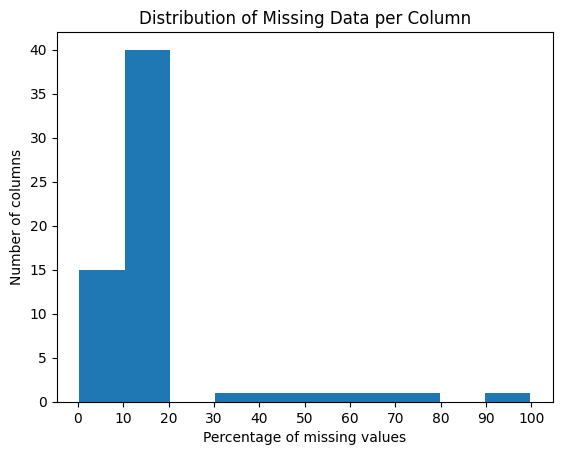

In [16]:
# Investigate patterns in the amount of missing data in each column.


plt.hist(null_values)
plt.title('Distribution of Missing Data per Column')
plt.xlabel('Percentage of missing values')
plt.ylabel('Number of columns')
plt.xticks(np.arange(0, 101, 10))
plt.show()



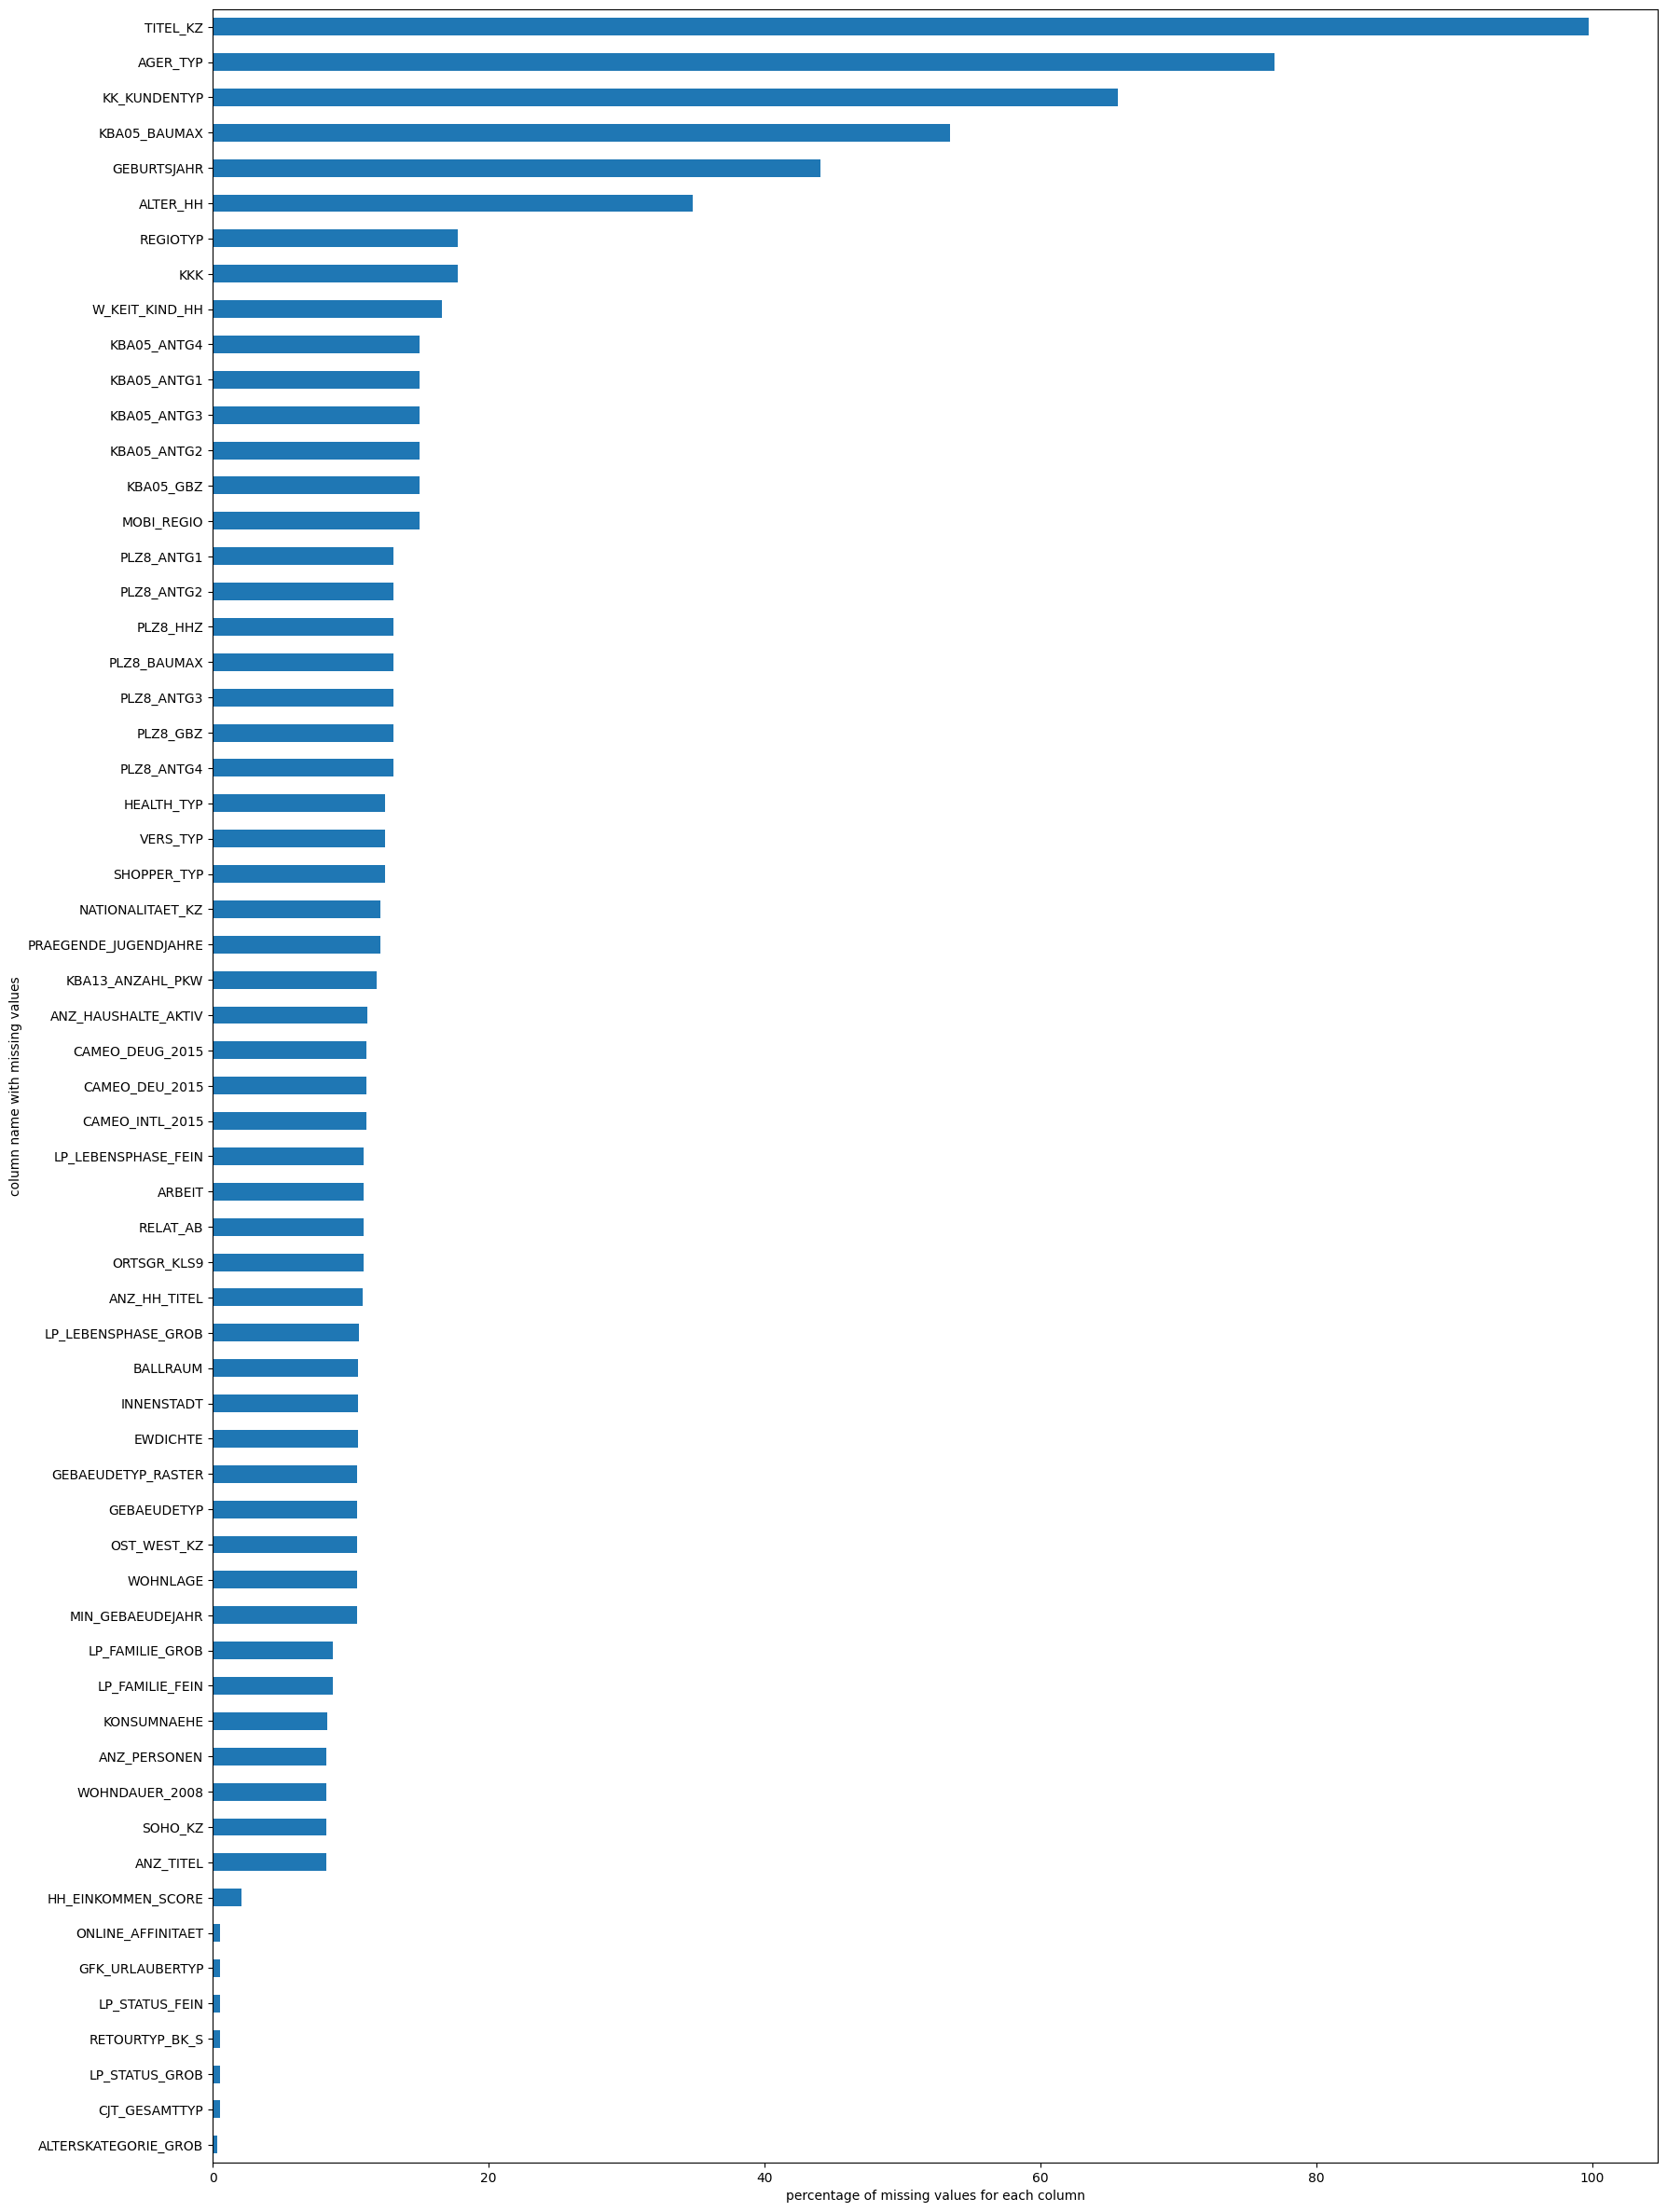

In [17]:
null_values.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values for each column')
plt.ylabel('column name with missing values')
plt.show()

In [18]:
null_values

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
LP_STATUS_GROB            0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
WOHNDAUER_2008            8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
MIN_GEBAEUDEJAHR         10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
GEBAEUDETYP              10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
INNENSTADT               10.518154
BALLRAUM                 10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
RELAT_AB                 10.926022
ARBEIT                   10.926022
LP_LEBENSPHASE_FEIN 

In [19]:
null_values[null_values>18].index

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns=null_values[null_values>18].index

AZDIAS.drop(columns=columns,axis="columns",inplace=True)

In [21]:
AZDIAS.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
AZDIAS.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

As we can see, there is a sharp increase in NaN values from REGIOTYP to ALTER_HH, suggesting that this point could serve as a threshold for defining the outlier group. What has been removed (with missing values as % shown):
ALTER_HH                 34.813699
GEBURTSJAHR              44.020282
KBA05_BAUMAX             53.468668
KK_KUNDENTYP             65.596749
AGER_TYP                 76.955435
TITEL_KZ                 99.757636

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

num_null_rows=AZDIAS.isnull().sum(axis=1)
num_null_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

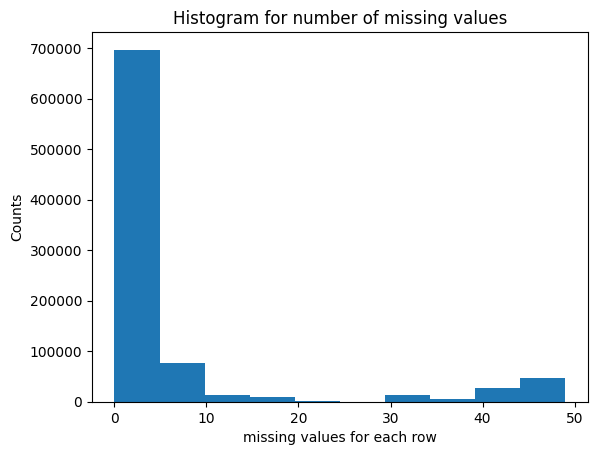

In [24]:
# How much data is missing in each row as hist

plt.hist(num_null_rows)
plt.xlabel('missing values for each row')
plt.ylabel('Counts')
plt.title('Histogram for number of missing values')
plt.show()

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#Threshold will be 20

missing_less_30=AZDIAS[num_null_rows<30]
missing_above_30=AZDIAS[num_null_rows>=30]

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns=null_values[null_values<18].index


In [27]:
top_few_missing_cols=columns[:5]

In [28]:
top_few_missing_cols

Index(['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'LP_STATUS_GROB',
       'RETOURTYP_BK_S', 'LP_STATUS_FEIN'],
      dtype='object')

In [29]:
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title('Missing values less than 30')
    sns.countplot(
        x=AZDIAS.loc[missing_less_30.index, column].dropna(),
        hue=AZDIAS.loc[missing_less_30.index, column].dropna(),
        ax=ax1,
        palette='Set2',
        legend=False
    )
    ax1.set_xlabel(column)
    ax1.tick_params(axis='x', rotation=45)

    ax2.set_title('Missing values above 30')
    sns.countplot(
        x=AZDIAS.loc[missing_above_30.index, column].dropna(),
        hue=AZDIAS.loc[missing_above_30.index, column].dropna(),
        ax=ax2,
        palette='Set2',
        legend=False
    )
    ax2.set_xlabel(column)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


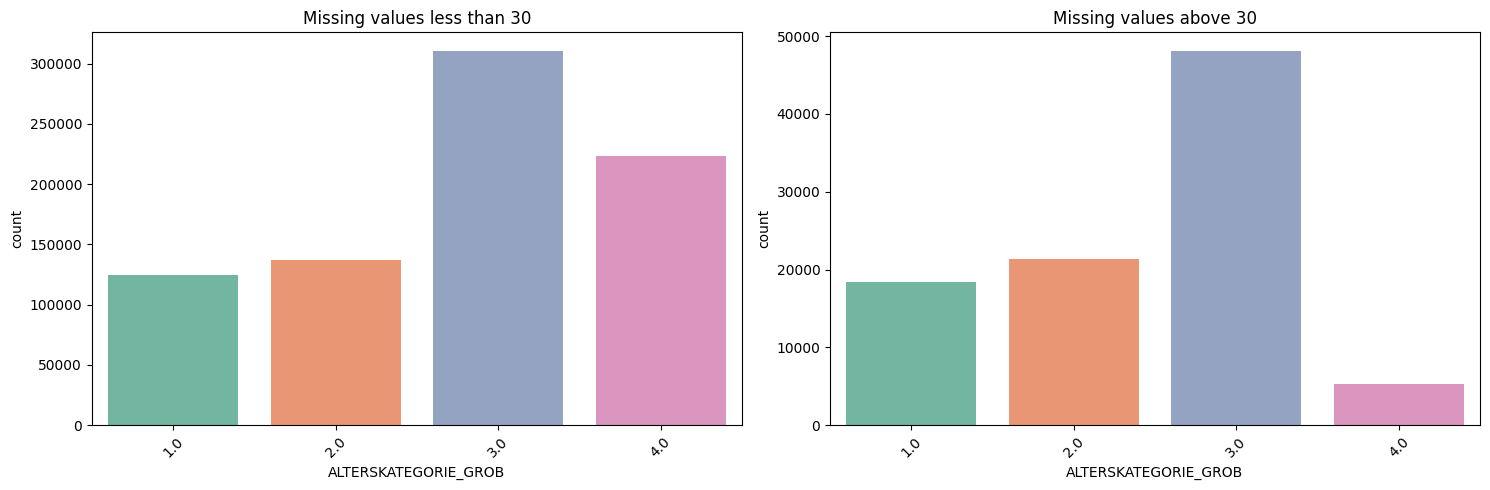

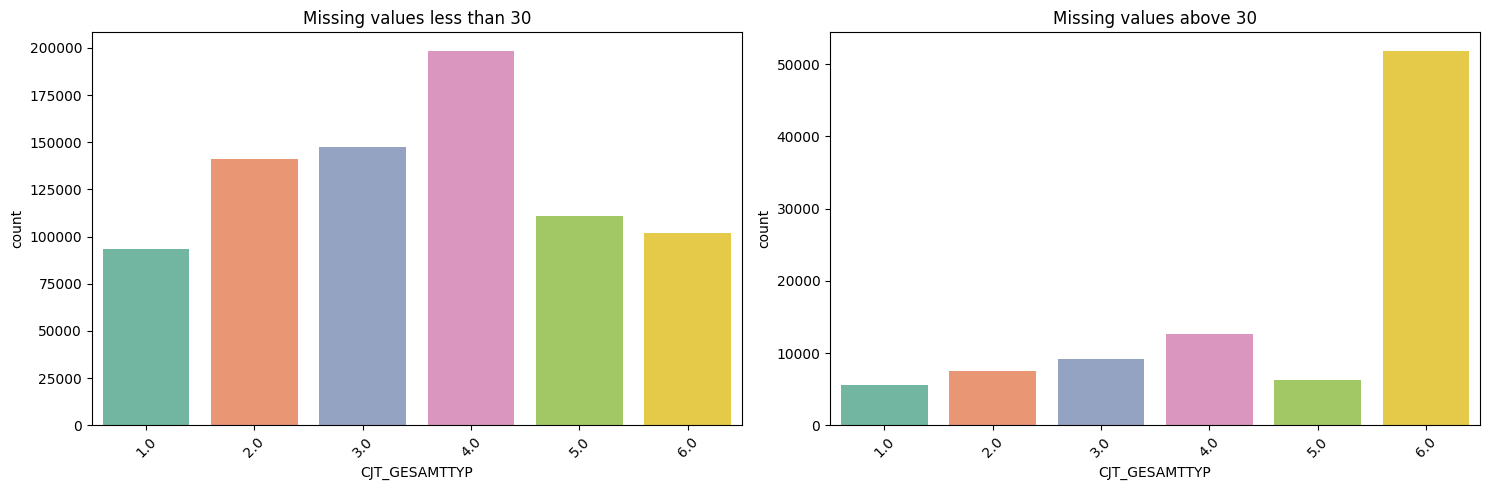

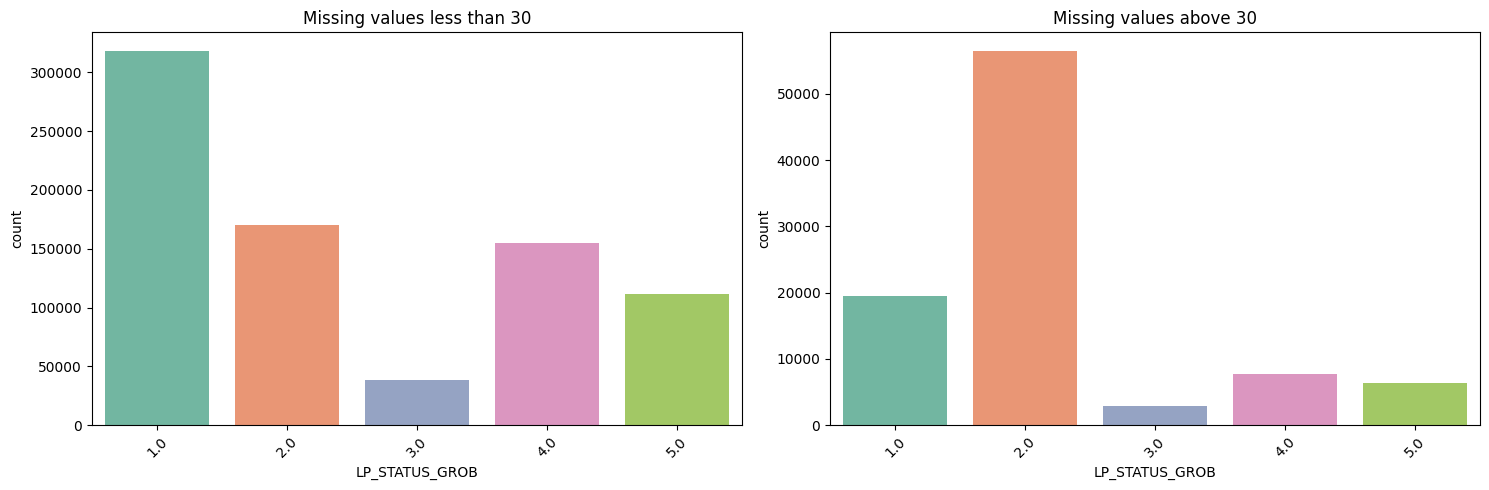

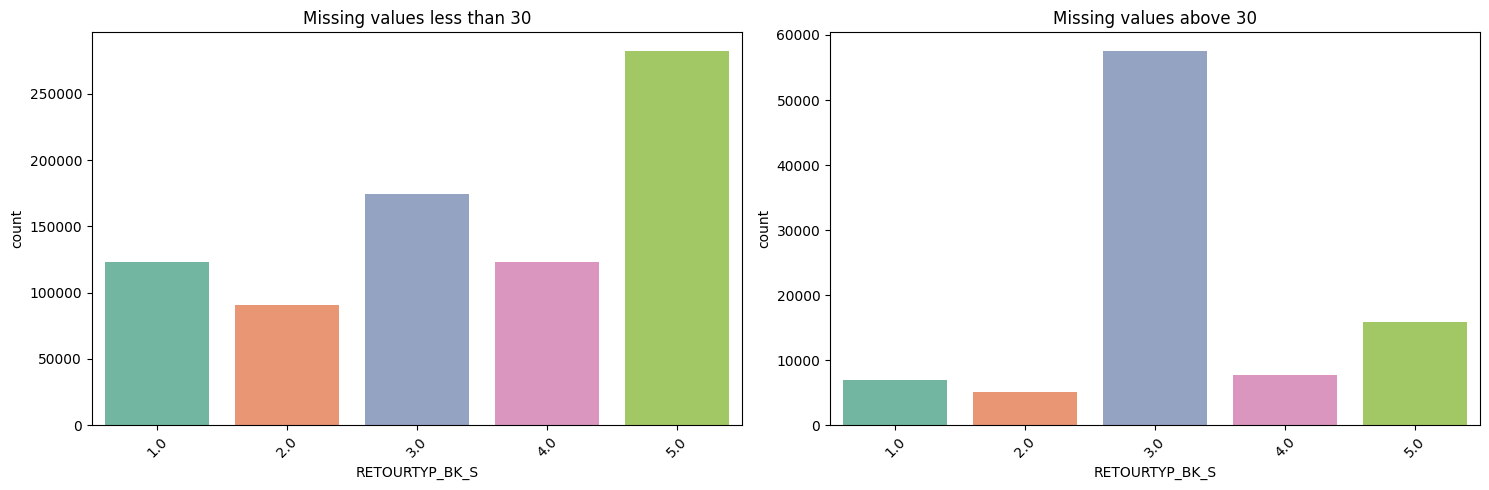

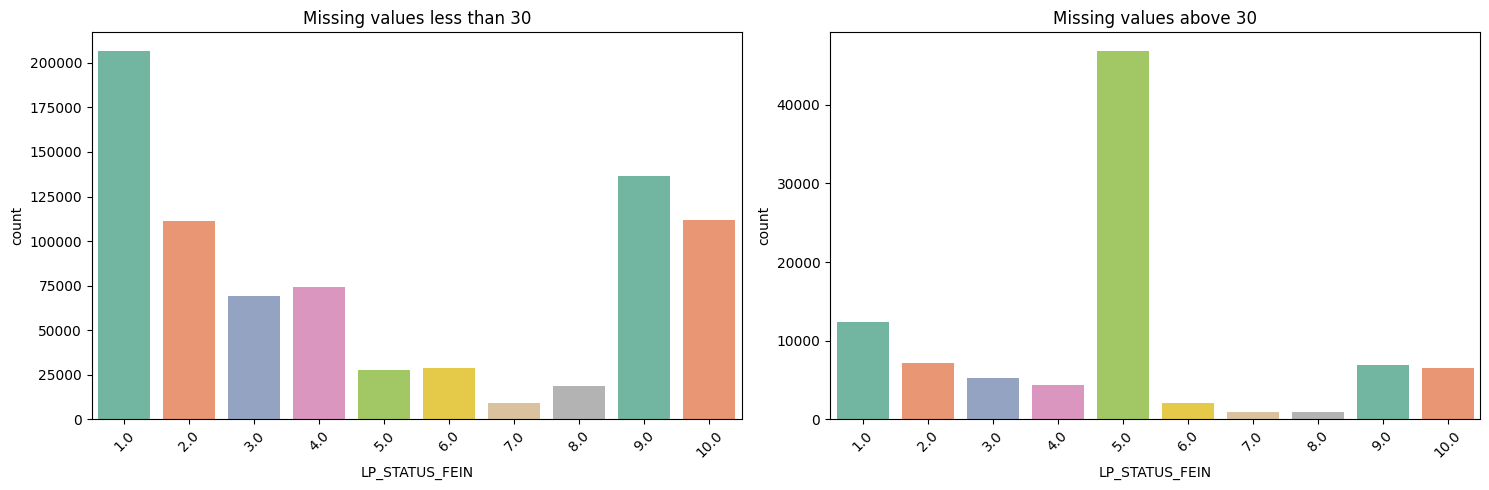

In [30]:
for i in range(top_few_missing_cols.size):
    create_plot(top_few_missing_cols[i])


#### Discussion 1.1.3: Assess Missing Data in Each Row

It looks like the data in the second subset (values above 30) are different compared to the first subset, i.e. we see less well distributed data and some "spike" like bars, that could be an indicator for quality issues with the subset.

In [31]:
missing_less_30 =missing_less_30.fillna(missing_less_30.mode().iloc[0])

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
feat_info=feat_info[feat_info.attribute.isin(missing_less_30.columns)]

In [33]:
feat_info.type.value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
categ_variables=feat_info[feat_info.type=="categorical"]

In [35]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#missing_less_30
binary_categories=[]
multi_level=[]

for col in categ_variables.attribute:
    if missing_less_30[col].nunique()==2:
        binary_categories.append(col)
    else:
        multi_level.append(col)

In [36]:
for col in binary_categories:
    print(missing_less_30[col].value_counts())

ANREDE_KZ
2.0    416177
1.0    381884
Name: count, dtype: int64
GREEN_AVANTGARDE
0    622836
1    175225
Name: count, dtype: int64
SOHO_KZ
0.0    791344
1.0      6717
Name: count, dtype: int64
VERS_TYP
2.0    430959
1.0    367102
Name: count, dtype: int64
OST_WEST_KZ
W    629520
O    168541
Name: count, dtype: int64


In [37]:
missing_less_30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
missing_less_30["SOHO_KZ"].replace({0.0:0, 1.0:1}, inplace=True)
missing_less_30["OST_WEST_KZ"].replace({'W':0, 'O':1}, inplace=True)
missing_less_30["OST_WEST_KZ"] = missing_less_30["OST_WEST_KZ"].astype(int)
missing_less_30=pd.get_dummies(data=missing_less_30,columns=multi_level)

C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2646701187.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["OST_WEST_KZ"].replace({'W':0, 'O':1}, inplace=True)


In [38]:
missing_less_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798061 entries, 1 to 891220
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: bool(128), float64(63), int64(2), object(1)
memory usage: 505.4+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

We discovered that 5 features are binary, whereof the "OST_WEST_KZ" was non-numeric. It contained "W" and "O", therefore W was set to "0" and "O" to "1". Multi-Level categoricals values were re-encoded using get_dummies to convert them into dummy/indicator variables - i.e. one hot encoding. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

missing_less_30.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [40]:
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

missing_less_30["DECADE"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
missing_less_30["MOVEMENT"]=missing_less_30.PRAEGENDE_JUGENDJAHRE

In [41]:
missing_less_30["DECADE"].replace(decade_dic,inplace=True)

In [42]:
missing_less_30["MOVEMENT"].replace(movement_dic,inplace=True)

In [43]:
missing_less_30.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#Wealth + LifeStage dictionary

wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

#create two features
missing_less_30["WEALTH"]=missing_less_30.CAMEO_INTL_2015
missing_less_30["LIFE_STAGE"]=missing_less_30.CAMEO_INTL_2015
#replace with new variables
missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
missing_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)
#drop the CAMEO_INTL_2015 column
missing_less_30.drop("CAMEO_INTL_2015",axis=1,inplace=True)


C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\120012595.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\120012595.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

Both mixed features were kept, but with different approaches.

The "Praegende Jugendjahre" has been split into two new variables (DECADE, MOVEMENT). DECADE has been classified as 6 different decades (40s to 90S), while MOVEMENT is either "Mainstream" or "Avantgarde". E+W has been left out as we see too many mixed catogeries.

For CAMEO_INTL_2015, we can see the following:
1 stands for the Wealth Status, 2 for the Age - so the 2 digit number was broken up into two new variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_variables=feat_info[feat_info.type=="mixed"]
for mixed_feature in mixed_variables["attribute"]:
    if mixed_feature in missing_less_30.columns:
        missing_less_30.drop(mixed_feature,axis=1,inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_values=missing_splited(feat_info["missing_or_unknown"])
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
        if missing_values_list[0] != "": # if the list not empty 
            for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan
    
    

    # remove selected columns and rows, ...
    #drop columns 
    columns=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
    df.drop(columns=columns,axis="columns",inplace=True)
    #rows
    num_null_rows=df.isnull().sum(axis=1)
    missing_less_30=df[num_null_rows<30]
    missing_above_30=df[num_null_rows>=30]
    missing_less_30 =missing_less_30.fillna(missing_less_30.mode().iloc[0])
     
    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(missing_less_30.columns)]
    categ_variables=feat_info[feat_info.type=="categorical"]
    
    binary_categories=[]
    multi_level=[]

    for col in categ_variables.attribute:
        if missing_less_30[col].nunique()==2:
            binary_categories.append(col)
        else:
            multi_level.append(col)
            
    # Re-encode categorical variable(s) to be kept in the analysis.
    missing_less_30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    missing_less_30["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    missing_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
    missing_less_30=pd.get_dummies(data=missing_less_30,columns=multi_level)
    
    #create dictionary to be used to re-engineer the mixed variables
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    
    #create new features
    missing_less_30["DECADE"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    missing_less_30["MOVEMENT"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    
    #replace with new variables
    missing_less_30["DECADE"].replace(decade_dic,inplace=True)
    missing_less_30["MOVEMENT"].replace(movement_dic,inplace=True)
    
    
    #Wealth and Life Stage dict
    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }
    
    #create two features
    missing_less_30["WEALTH"]=missing_less_30.CAMEO_INTL_2015
    missing_less_30["LIFE_STAGE"]=missing_less_30.CAMEO_INTL_2015
    #replace with new variables
    missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
    missing_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)
    
    #drop mixed-type features which including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in missing_less_30.columns:
            missing_less_30.drop(mixed_feature,axis=1,inplace=True)
    

    # Return the cleaned dataframe.
    return missing_less_30

In [48]:
AZDIAS_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
test_df=clean_data(AZDIAS_test,feat_info)

C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
missing_less_30.isnull().sum().sum()

np.int64(0)

In [50]:
columns_to_drop = [
    # LP_FAMILIE_FEIN
    "LP_FAMILIE_FEIN_1.0", "LP_FAMILIE_FEIN_2.0", "LP_FAMILIE_FEIN_3.0", "LP_FAMILIE_FEIN_4.0",
    "LP_FAMILIE_FEIN_5.0", "LP_FAMILIE_FEIN_6.0", "LP_FAMILIE_FEIN_7.0", "LP_FAMILIE_FEIN_8.0",
    "LP_FAMILIE_FEIN_9.0", "LP_FAMILIE_FEIN_10.0", "LP_FAMILIE_FEIN_11.0",

    # LP_FAMILIE_GROB
    "LP_FAMILIE_GROB_1.0", "LP_FAMILIE_GROB_2.0", "LP_FAMILIE_GROB_3.0", "LP_FAMILIE_GROB_4.0", "LP_FAMILIE_GROB_5.0",

    # LP_STATUS_FEIN
    "LP_STATUS_FEIN_1.0", "LP_STATUS_FEIN_2.0", "LP_STATUS_FEIN_3.0", "LP_STATUS_FEIN_4.0", "LP_STATUS_FEIN_5.0",
    "LP_STATUS_FEIN_6.0", "LP_STATUS_FEIN_7.0", "LP_STATUS_FEIN_8.0", "LP_STATUS_FEIN_9.0", "LP_STATUS_FEIN_10.0",

    # LP_STATUS_GROB
    "LP_STATUS_GROB_1.0", "LP_STATUS_GROB_2.0", "LP_STATUS_GROB_3.0", "LP_STATUS_GROB_4.0", "LP_STATUS_GROB_5.0",

    # GEBAEUDETYP
    "GEBAEUDETYP_1.0", "GEBAEUDETYP_2.0", "GEBAEUDETYP_3.0", "GEBAEUDETYP_4.0",
    "GEBAEUDETYP_5.0", "GEBAEUDETYP_6.0", "GEBAEUDETYP_8.0",

    # CAMEO_DEUG_2015
    "CAMEO_DEUG_2015_1", "CAMEO_DEUG_2015_2", "CAMEO_DEUG_2015_3", "CAMEO_DEUG_2015_4", "CAMEO_DEUG_2015_5",
    "CAMEO_DEUG_2015_6", "CAMEO_DEUG_2015_7", "CAMEO_DEUG_2015_8", "CAMEO_DEUG_2015_9",

    # CAMEO_DEU_2015
    "CAMEO_DEU_2015_1A", "CAMEO_DEU_2015_1B", "CAMEO_DEU_2015_1C", "CAMEO_DEU_2015_1D", "CAMEO_DEU_2015_1E",
    "CAMEO_DEU_2015_2A", "CAMEO_DEU_2015_2B", "CAMEO_DEU_2015_2C", "CAMEO_DEU_2015_2D",
    "CAMEO_DEU_2015_3A", "CAMEO_DEU_2015_3B", "CAMEO_DEU_2015_3C", "CAMEO_DEU_2015_3D",
    "CAMEO_DEU_2015_4A", "CAMEO_DEU_2015_4B", "CAMEO_DEU_2015_4C", "CAMEO_DEU_2015_4D", "CAMEO_DEU_2015_4E",
    "CAMEO_DEU_2015_5A", "CAMEO_DEU_2015_5B", "CAMEO_DEU_2015_5C", "CAMEO_DEU_2015_5D", "CAMEO_DEU_2015_5E", "CAMEO_DEU_2015_5F",
    "CAMEO_DEU_2015_6A", "CAMEO_DEU_2015_6B", "CAMEO_DEU_2015_6C", "CAMEO_DEU_2015_6D", "CAMEO_DEU_2015_6E", "CAMEO_DEU_2015_6F",
    "CAMEO_DEU_2015_7A", "CAMEO_DEU_2015_7B", "CAMEO_DEU_2015_7C", "CAMEO_DEU_2015_7D", "CAMEO_DEU_2015_7E",
    "CAMEO_DEU_2015_8A", "CAMEO_DEU_2015_8B", "CAMEO_DEU_2015_8C", "CAMEO_DEU_2015_8D",
    "CAMEO_DEU_2015_9A", "CAMEO_DEU_2015_9B", "CAMEO_DEU_2015_9C", "CAMEO_DEU_2015_9D", "CAMEO_DEU_2015_9E"
]

# Drop the defined Features
missing_less_30.drop(columns=columns_to_drop, inplace=True)

In [51]:
print(len(missing_less_30.columns))
for col in missing_less_30.columns:
    print(col)

101
ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
VERS_TYP
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1.0
FINANZTYP_2.0
FINANZTYP_3.0
FINANZTYP_4.0
FINANZTYP_5.0
FINANZTYP_6.0
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.

In [52]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()
features_scaled=scaler.fit_transform(missing_less_30)

In [53]:
features_scaled=pd.DataFrame(features_scaled,columns=missing_less_30.columns.tolist())

In [54]:
features_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766646,-0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,-1.685445,0.443199,-0.059352,0.002844,-0.463904,-1.684514,-1.109907,-1.435376,-0.578167,1.274182,-0.312190,1.339259,-0.157562,1.518695,1.288982,10.854129,0.922944,0.234451,-0.060408,1.026714,-0.730190,0.567325,0.173103,-0.125134,-1.304534,-0.383170,-0.517426,-1.008844,-0.965697,-0.594877,2.730663,-1.659268,0.845251,-0.547163,1.701104,-0.799737,-0.791625,-1.279724,0.166969,-0.882464,0.942531,-0.256529,0.211982,0.402979,0.442528,1.455847,0.574305,-0.171400,-0.127041,0.684882,-0.363872,-0.463777,-0.475604,-0.58415,2.486436,-0.383034,1.745726,-0.388748,-0.24388,-0.274504,-0.392070,-0.753591,-0.260346,-0.241143,-0.266984,-0.286204,-0.311289,-0.182556,-0.23176,-0.340765,-0.277682,2.600173,-0.322309,-0.451234,0.370257,-0.294397,-0.206255,-0.435292,-0.743551,-0.589735,1.847287,-0.427793,-0.207703,-0.739707,-0.592817,2.976110,-0.312172,1.098070,0.530409,1.175657,-1.252793
1,0.200522,-0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,-0.310894,-0.072018,-1.626988,-0.520579,-0.463904,-0.142556,-0.158738,0.754258,-0.578167,0.064234,1.392000,1.339259,1.448744,-0.638939,-0.410211,-0.092131,-1.083489,-0.630205,-0.060408,-0.267579,-0.730190,0.567325,0.109099,-0.125134,1.274841,-0.383170,-0.517426,-0.297927,1.444748,0.408128,-0.464086,-0.116193,-0.986687,0.034481,-0.271085,0.283471,-0.791625,0.092840,-0.476476,-1.435265,0.227670,0.786627,0.211982,-0.623106,-0.934798,0.419740,0.574305,-0.171400,-0.127041,-0.789027,-0.363872,-0.463777,2.102587,-0.58415,-0.402182,-0.383034,1.745726,-0.388748,-0.24388,-0.274504,-0.392070,-0.753591,-0.260346,-0.241143,-0.266984,-0.286204,-0.311289,-0.182556,-0.23176,-0.340765,-0.277682,2.600173,-0.322309,-0.451234,0.370257,-0.294397,-0.206255,-0.435292,-0.743551,1.695678,-0.541335,-0.427793,-0.207703,-0.739707,-0.592817,2.976110,-0.312172,1.098070,-1.885336,-0.869680,0.756034
2,1.184106,-0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,-0.998170,0.443199,-1.626988,-1.044002,-1.509273,-0.142556,-0.158738,1.301667,-0.067380,-0.540740,-0.312190,-0.303541,0.377873,-0.099530,0.156187,-0.092131,-1.083489,-1.494862,-0.060408,-2.209018,0.957033,0.567325,-0.466933,-0.125134,0.629997,1.117367,-0.517426,1.834823,-0.162215,-0.594877,-0.464086,0.655345,-0.070718,-1.128807,0.715010,0.283471,0.269703,0.779122,-1.119921,0.775939,-0.102704,-0.256529,-0.890120,0.402979,-0.934798,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,-0.363872,2.156207,-0.475604,-0.58415,-0.402182

In [55]:
features_scaled.describe().T[["mean", "std"]]

,mean,std
ALTERSKATEGORIE_GROB,-2.849076e-18,1.000001
ANREDE_KZ,2.222280e-17,1.000001
FINANZ_MINIMALIST,-1.166697e-16,1.000001
FINANZ_SPARER,8.860628e-17,1.000001
FINANZ_VORSORGER,1.233650e-16,1.000001
FINANZ_ANLEGER,-7.322126e-17,1.000001
FINANZ_UNAUFFAELLIGER,-1.566992e-16,1.000001
FINANZ_HAUSBAUER,-1.170970e-16,1.000001
GREEN_AVANTGARDE,-1.310575e-17,1.000001
HEALTH_TYP,-1.625398e-16,1.000001


### Discussion 2.1: Apply Feature Scaling

After checking for any NaN values, none are present anymore (due to the decision to use the mode to replace missing values for the left side of the defined threshold (i.e. <30 missing values). I had to drop multiple features as the connection to the ipykernel disconnects if too many features are used (known problem, see the knowledge base). I tried to delete those that seem not too important for the analysis. Using sklearn Standard Scaler is a proven approach for scaling data to close to 0 mean and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [56]:
# Apply PCA to the data.

pca = PCA()
pca.fit(features_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


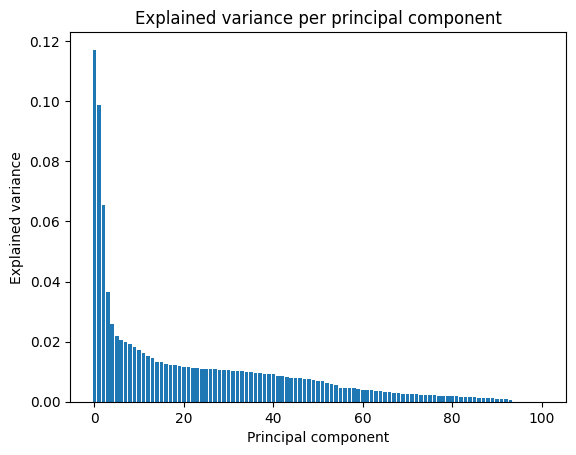

In [57]:
# Investigate the variance accounted for by each principal component.

num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

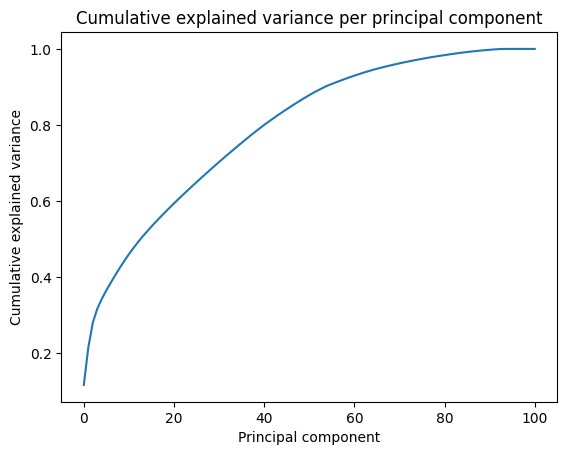

In [58]:
cum_vals = np.cumsum(values)
plt.plot(num_components,cum_vals)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_60 = PCA(n_components=60)
data_PCA = pca_60.fit_transform(features_scaled)

In [60]:
# Get explained variance ratios
explained_variance_ratio = pca_60.explained_variance_ratio_

# Compute cumulative explained variance
cum_vals = np.cumsum(explained_variance_ratio)

# Get cumulative variance at the 60th component (index 59)
pc_index = 59  # Python is zero-based
pc60_cumulative_variance = cum_vals[pc_index] * 100  # Convert to percentage

print(f"Cumulative explained variance at the 60th principal component: {pc60_cumulative_variance:.2f}%")


Cumulative explained variance at the 60th principal component: 92.57%


### Discussion 2.2: Perform Dimensionality Reduction

We can see that there is small to zero increase in explained variance from 80 to 100 Principal Components.

Also here, the Kernel keeps disconnection when using even 65 components, so I decided to use 60 to keep the model alive, as it also explains 92.55% of the variance, that should be sufficient.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

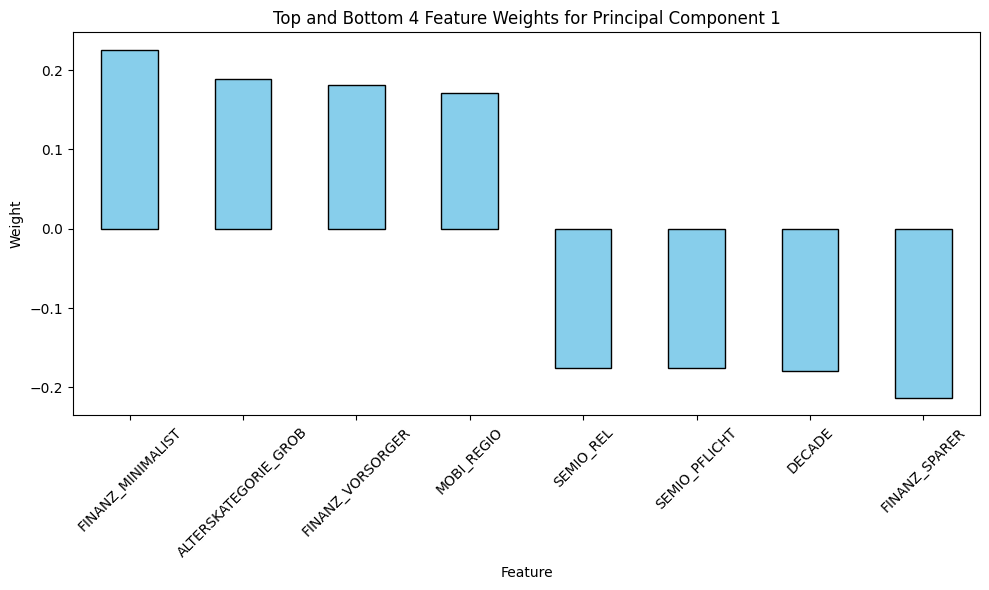

FINANZ_MINIMALIST       0.225687
ALTERSKATEGORIE_GROB    0.188952
FINANZ_VORSORGER        0.181575
MOBI_REGIO              0.170561
SEMIO_REL              -0.175222
SEMIO_PFLICHT          -0.176070
DECADE                 -0.179356
FINANZ_SPARER          -0.213552
Name: 0, dtype: float64


In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

import pandas as pd
import matplotlib.pyplot as plt

def PCA_weights(df, pca, n):
    # Get weights for the nth principal component
    weights_df = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[n]
    
    # Sort weights
    sorted_weights = weights_df.sort_values(ascending=False)
    
    # Select top 4 and bottom 4
    top_bottom = pd.concat([sorted_weights.head(4), sorted_weights.tail(4)])
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    top_bottom.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Top and Bottom 4 Feature Weights for Principal Component {n+1}')
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return top_bottom


weights_df = PCA_weights(features_scaled, pca_60, 0)
print(weights_df)

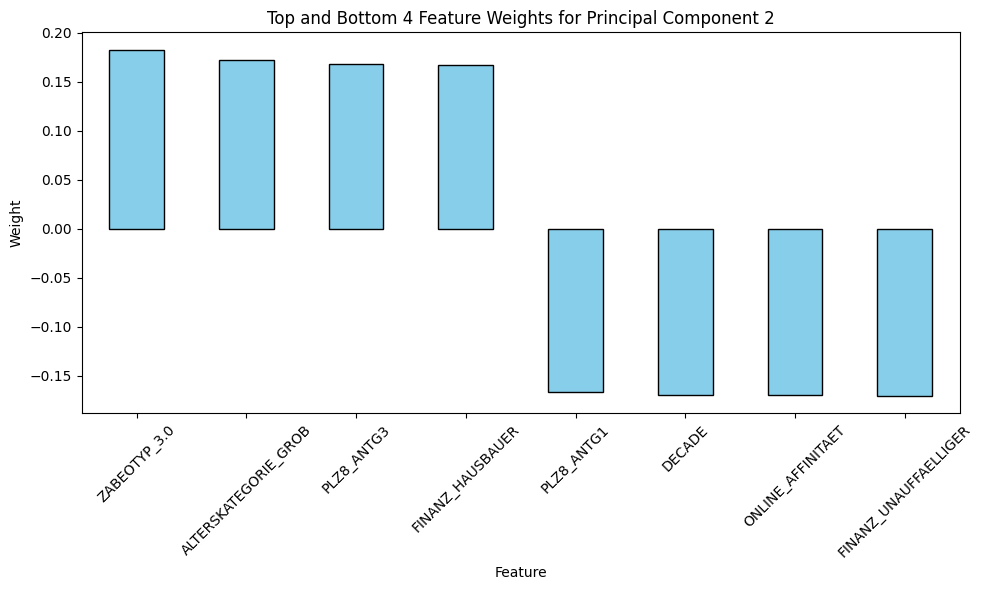

ZABEOTYP_3.0             0.182550
ALTERSKATEGORIE_GROB     0.171801
PLZ8_ANTG3               0.167896
FINANZ_HAUSBAUER         0.167083
PLZ8_ANTG1              -0.166932
DECADE                  -0.169086
ONLINE_AFFINITAET       -0.169645
FINANZ_UNAUFFAELLIGER   -0.170416
Name: 1, dtype: float64


In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

import pandas as pd
import matplotlib.pyplot as plt

def PCA_weights(df, pca, n):
    # Get weights for the nth principal component
    weights_df = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[n]
    
    # Sort weights
    sorted_weights = weights_df.sort_values(ascending=False)
    
    # Select top 4 and bottom 4
    top_bottom = pd.concat([sorted_weights.head(4), sorted_weights.tail(4)])
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    top_bottom.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Top and Bottom 4 Feature Weights for Principal Component {n+1}')
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return top_bottom


weights_df = PCA_weights(features_scaled, pca_60, 1)
print(weights_df)

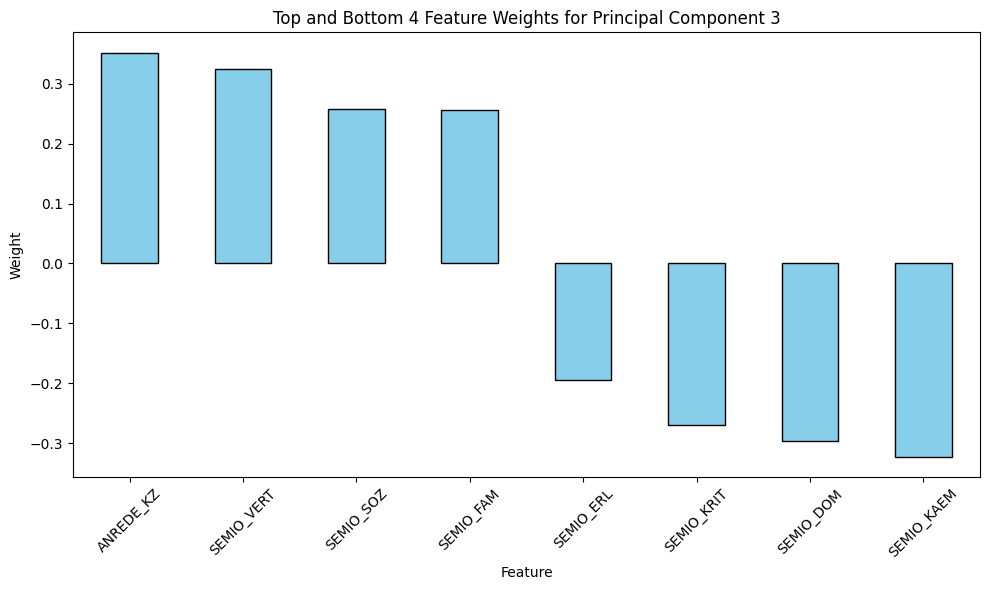

ANREDE_KZ     0.352184
SEMIO_VERT    0.325170
SEMIO_SOZ     0.257587
SEMIO_FAM     0.256281
SEMIO_ERL    -0.194911
SEMIO_KRIT   -0.269957
SEMIO_DOM    -0.297193
SEMIO_KAEM   -0.322670
Name: 2, dtype: float64


In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

import pandas as pd
import matplotlib.pyplot as plt

def PCA_weights(df, pca, n):
    # Get weights for the nth principal component
    weights_df = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[n]
    
    # Sort weights
    sorted_weights = weights_df.sort_values(ascending=False)
    
    # Select top 4 and bottom 4
    top_bottom = pd.concat([sorted_weights.head(4), sorted_weights.tail(4)])
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    top_bottom.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Top and Bottom 4 Feature Weights for Principal Component {n+1}')
    plt.ylabel('Weight')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return top_bottom


weights_df = PCA_weights(features_scaled, pca_60, 2)
print(weights_df)

### Discussion 2.3: Interpret Principal Components

PCA 1:
Positive weights: 
+ Finanz_SPARER (money_saver)
+ Decade (what decade born/generation)
+ Semio_PFLICHT (dutiful) 
+ Semio_REL (religious)

Negative weights: 
- Mobi_Regio (Movement_Patterns)
- Finanz_Vorsorge (financially prepared)
- Alterskategorie_Grob (estimated age based on given name analysis)
- Finanz_Minimalist (low financial interest)

PCA 2:
Positive weights:
+ Zabeotyp 3.0 (fair supplied)
+ Alterskategorie_Grob (estimated age based on given name analysis)
+ PLZ8_ANTG3 (Member of 6-10 family house in the PLZ8 region)
+ FIN_Hausbauer (home ownership)

Negative weights:
- PLZ8_ANTG1 (1-2family housing in the microcell)
- Decade (what decade born/generation)
- Online_Affinitaet (online affinity)
- Fin_Unauffaelliger (financially inconspicious)

PCA 3:
Positive weights:
+ Anrede_KZ (Gender)
+ Semio_VERT (dreamful)
+ Semio_SOZ (socially minded)
+ Semio_FAM (familly minded)

Negative weights:
- Semio_ERL (event oriented)
- Semio_KRIT (critical minded)
- Semio_DOM (dominant minded)
- Semio_KAEM (combative minded)


We can ovserve that the first component seems to be about conservatism, financial awareness and age/decade of birth.
PC 2 can be seen as impacted by financial status (home ownership e.g.) and age as well as the size of the house as a member.
PC 3 has a clear relationship with personal orientation and gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    
num_clusters=np.arange(10,21)
scores=[]
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data_PCA)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data_PCA))
    scores.append(score)
    

In [65]:
num_clusters

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

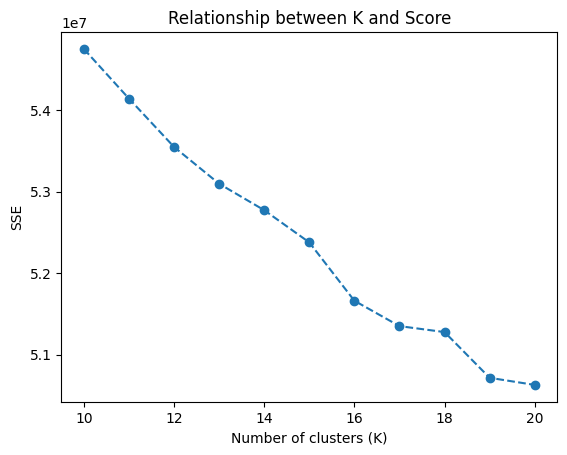

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(num_clusters,scores,marker='o',linestyle='--')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.title("Relationship between K and Score")
plt.show()



In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=19)
model=kmeans.fit(data_PCA)
data_pred=model.predict(data_PCA)

### Discussion 3.1: Apply Clustering to General Population

After plotting the relationship between the numbers of clusters and the SSE, we can not observe an elbow like shape. There is a kind of short stall between 13 and 14 clusters, but afterwards, SSE start to decrease again. I will choose 19 for now.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [69]:

print(f"Number of columns: {len(customers.columns)}")
print("Columns:", customers.columns.tolist())


Number of columns: 85
Columns: ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2

In [70]:
customers_clean= clean_data(customers,feat_info)

C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
C:\Users\Lukas Nahm\AppData\Local\Temp\ipykernel_14728\2782344337.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

In [71]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

list(set(test_df)-set(customers_clean.columns))


['GEBAEUDETYP_5.0']

In [72]:
#add missing column and fill with 0
customers_clean["GEBAEUDETYP_5.0"] = 0

In [73]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,0.0,1,3,0
2,4.0,0.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,0.0,3,4,0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,4.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,1.0,2,4,0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,4.0,1.0,4,1,0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,0.0,3,4,0


In [74]:
#check for 0 Nan values in customers_clean
customers_clean.isnull().sum().sum()

np.int64(0)

In [75]:
#needed data cleansing due to kernel disconnection when used too many features, as explained above
columns_to_drop = [
    # LP_FAMILIE_FEIN
    "LP_FAMILIE_FEIN_1.0", "LP_FAMILIE_FEIN_2.0", "LP_FAMILIE_FEIN_3.0", "LP_FAMILIE_FEIN_4.0",
    "LP_FAMILIE_FEIN_5.0", "LP_FAMILIE_FEIN_6.0", "LP_FAMILIE_FEIN_7.0", "LP_FAMILIE_FEIN_8.0",
    "LP_FAMILIE_FEIN_9.0", "LP_FAMILIE_FEIN_10.0", "LP_FAMILIE_FEIN_11.0",

    # LP_FAMILIE_GROB
    "LP_FAMILIE_GROB_1.0", "LP_FAMILIE_GROB_2.0", "LP_FAMILIE_GROB_3.0", "LP_FAMILIE_GROB_4.0", "LP_FAMILIE_GROB_5.0",

    # LP_STATUS_FEIN
    "LP_STATUS_FEIN_1.0", "LP_STATUS_FEIN_2.0", "LP_STATUS_FEIN_3.0", "LP_STATUS_FEIN_4.0", "LP_STATUS_FEIN_5.0",
    "LP_STATUS_FEIN_6.0", "LP_STATUS_FEIN_7.0", "LP_STATUS_FEIN_8.0", "LP_STATUS_FEIN_9.0", "LP_STATUS_FEIN_10.0",

    # LP_STATUS_GROB
    "LP_STATUS_GROB_1.0", "LP_STATUS_GROB_2.0", "LP_STATUS_GROB_3.0", "LP_STATUS_GROB_4.0", "LP_STATUS_GROB_5.0",

    # GEBAEUDETYP
    "GEBAEUDETYP_1.0", "GEBAEUDETYP_2.0", "GEBAEUDETYP_3.0", "GEBAEUDETYP_4.0",
    "GEBAEUDETYP_5.0", "GEBAEUDETYP_6.0", "GEBAEUDETYP_8.0",

    # CAMEO_DEUG_2015
    "CAMEO_DEUG_2015_1", "CAMEO_DEUG_2015_2", "CAMEO_DEUG_2015_3", "CAMEO_DEUG_2015_4", "CAMEO_DEUG_2015_5",
    "CAMEO_DEUG_2015_6", "CAMEO_DEUG_2015_7", "CAMEO_DEUG_2015_8", "CAMEO_DEUG_2015_9",

    # CAMEO_DEU_2015
    "CAMEO_DEU_2015_1A", "CAMEO_DEU_2015_1B", "CAMEO_DEU_2015_1C", "CAMEO_DEU_2015_1D", "CAMEO_DEU_2015_1E",
    "CAMEO_DEU_2015_2A", "CAMEO_DEU_2015_2B", "CAMEO_DEU_2015_2C", "CAMEO_DEU_2015_2D",
    "CAMEO_DEU_2015_3A", "CAMEO_DEU_2015_3B", "CAMEO_DEU_2015_3C", "CAMEO_DEU_2015_3D",
    "CAMEO_DEU_2015_4A", "CAMEO_DEU_2015_4B", "CAMEO_DEU_2015_4C", "CAMEO_DEU_2015_4D", "CAMEO_DEU_2015_4E",
    "CAMEO_DEU_2015_5A", "CAMEO_DEU_2015_5B", "CAMEO_DEU_2015_5C", "CAMEO_DEU_2015_5D", "CAMEO_DEU_2015_5E", "CAMEO_DEU_2015_5F",
    "CAMEO_DEU_2015_6A", "CAMEO_DEU_2015_6B", "CAMEO_DEU_2015_6C", "CAMEO_DEU_2015_6D", "CAMEO_DEU_2015_6E", "CAMEO_DEU_2015_6F",
    "CAMEO_DEU_2015_7A", "CAMEO_DEU_2015_7B", "CAMEO_DEU_2015_7C", "CAMEO_DEU_2015_7D", "CAMEO_DEU_2015_7E",
    "CAMEO_DEU_2015_8A", "CAMEO_DEU_2015_8B", "CAMEO_DEU_2015_8C", "CAMEO_DEU_2015_8D",
    "CAMEO_DEU_2015_9A", "CAMEO_DEU_2015_9B", "CAMEO_DEU_2015_9C", "CAMEO_DEU_2015_9D", "CAMEO_DEU_2015_9E"
]

# Drop the defined Features
customers_clean.drop(columns=columns_to_drop, inplace=True)

In [76]:
#feature transformation
customers_scaled=scaler.fit_transform(customers_clean)
customers_scaled=pd.DataFrame(customers_scaled,columns=customers_clean.columns.tolist())
customers_pca=pca_60.transform(customers_scaled)

In [77]:
#customers_scaled
pred_customers= model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [78]:
# After fitting PCA
components_df = pd.DataFrame(
    pca_60.components_,
    columns=customers_clean.columns,
    index=[f'PC{i+1}' for i in range(pca_60.n_components)]
)

print(components_df.head(18))  # Shows first few components

      ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER       KKK  MOBI_REGIO  ONLINE_AFFINITAET  REGIOTYP  ...  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ    ARBEIT  ORTSGR_KLS9  RELAT_AB  CJT_GESAMTTYP_1.0  CJT_GESAMTTYP_2.0  CJT_GESAMTTYP_3.0  CJT_GESAMTTYP_4.0  CJT_GESAMTTYP_5.0  CJT_GESAMTTYP_6.0  FINANZTYP_1.0  FINANZTYP_2.0  FINANZTYP_3.0  FINANZTYP_4.0  FINANZTYP_5.0  \
PC

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_plot(general, customers):
    # Convert inputs to pandas Series if they aren't already
    general_series = pd.Series(general)
    customers_series = pd.Series(customers)

    # Calculate value counts and percentages
    general_counts = general_series.value_counts(normalize=True) * 100
    customer_counts = customers_series.value_counts(normalize=True) * 100

    # Generate distinct colors for each bar
    general_colors = sns.color_palette("hsv", len(general_counts))
    customer_colors = sns.color_palette("hsv", len(customer_counts))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot general clusters
    sns.barplot(x=general_counts.index, y=general_counts.values, ax=ax1, palette=general_colors)
    ax1.set_title('General Clusters')
    ax1.set_ylabel('Percentage')
    ax1.set_ylim(0, max(general_counts.values) * 1.1)
    for p in ax1.patches:
        height = p.get_height()
        label = f'{height:.1f}%'
        ax1.annotate(label, (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom')

    # Plot customer clusters
    sns.barplot(x=customer_counts.index, y=customer_counts.values, ax=ax2, palette=customer_colors)
    ax2.set_title('Customer Clusters')
    ax2.set_ylabel('Percentage')
    ax2.set_ylim(0, max(customer_counts.values) * 1.1)
    for p in ax2.patches:
        height = p.get_height()
        label = f'{height:.1f}%'
        ax2.annotate(label, (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


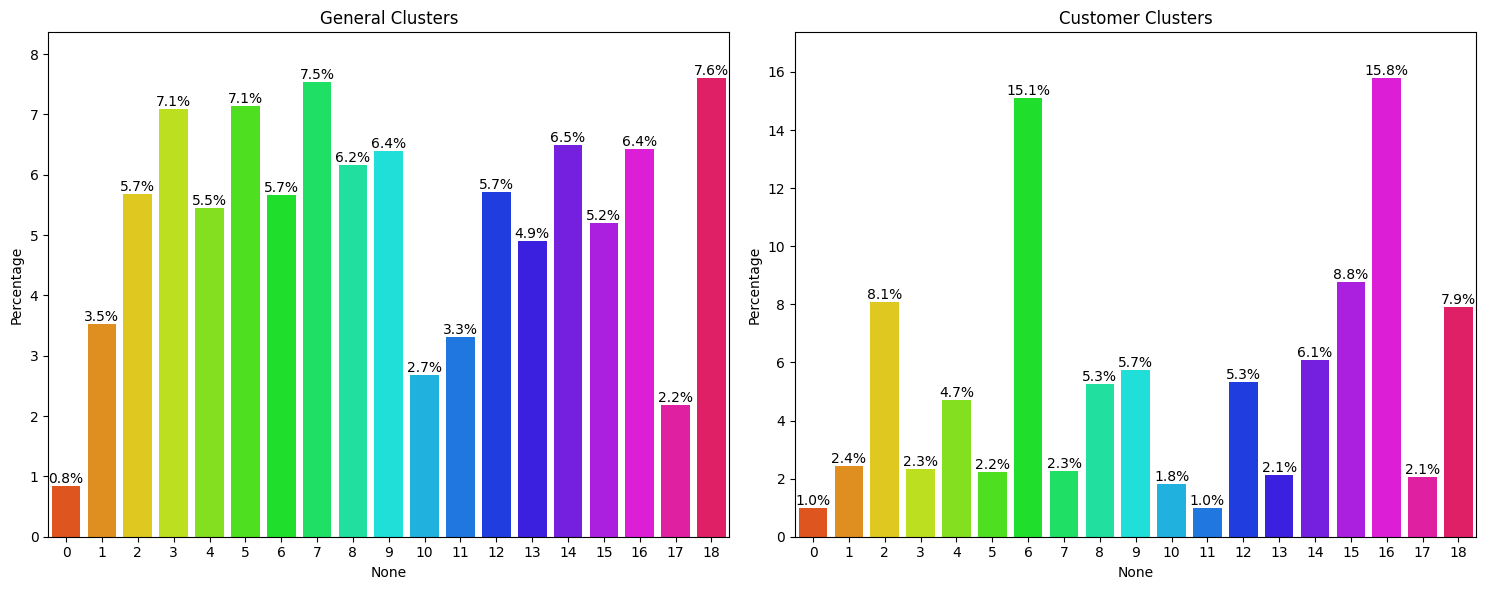

In [80]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

compare_plot(data_pred, pred_customers)

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(
    pca_60.inverse_transform(model.cluster_centers_[0].reshape(1, -1))
).flatten()

underrepresented_c = pd.Series(data=centroid_0, index=customers_clean.columns)
print(underrepresented_c)

ALTERSKATEGORIE_GROB        3.472670
ANREDE_KZ                   0.673902
FINANZ_MINIMALIST           4.301326
FINANZ_SPARER               1.429777
FINANZ_VORSORGER            4.567001
FINANZ_ANLEGER              1.605633
FINANZ_UNAUFFAELLIGER       1.887751
FINANZ_HAUSBAUER            2.664547
GREEN_AVANTGARDE            0.517886
HEALTH_TYP                  1.942239
RETOURTYP_BK_S              3.893045
SEMIO_SOZ                   4.383734
SEMIO_FAM                   3.886897
SEMIO_REL                   3.239862
SEMIO_MAT                   3.444415
SEMIO_VERT                  5.234854
SEMIO_LUST                  5.557412
SEMIO_ERL                   4.844670
SEMIO_KULT                  3.946291
SEMIO_RAT                   2.900914
SEMIO_KRIT                  3.841228
SEMIO_DOM                   3.960040
SEMIO_KAEM                  3.560330
SEMIO_PFLICHT               3.091785
SEMIO_TRADV                 2.895241
SOHO_KZ                     1.081226
VERS_TYP                    1.475445
A

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_1 = scaler.inverse_transform(
    pca_60.inverse_transform(model.cluster_centers_[1].reshape(1, -1))
).flatten()

underrepresented_c = pd.Series(data=centroid_1, index=customers_clean.columns)
print(underrepresented_c)


ALTERSKATEGORIE_GROB        3.031921
ANREDE_KZ                   0.884964
FINANZ_MINIMALIST           5.093442
FINANZ_SPARER               1.956582
FINANZ_VORSORGER            3.609310
FINANZ_ANLEGER              2.002042
FINANZ_UNAUFFAELLIGER       2.967939
FINANZ_HAUSBAUER            0.766553
GREEN_AVANTGARDE            0.823822
HEALTH_TYP                  2.006825
RETOURTYP_BK_S              3.167205
SEMIO_SOZ                   5.240857
SEMIO_FAM                   4.804428
SEMIO_REL                   4.133336
SEMIO_MAT                   4.094372
SEMIO_VERT                  6.062683
SEMIO_LUST                  5.019455
SEMIO_ERL                   3.810623
SEMIO_KULT                  5.154601
SEMIO_RAT                   3.269918
SEMIO_KRIT                  3.102685
SEMIO_DOM                   3.390229
SEMIO_KAEM                  2.757673
SEMIO_PFLICHT               3.841761
SEMIO_TRADV                 3.611326
SOHO_KZ                     0.000455
VERS_TYP                    1.438208
A

In [83]:
# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Centroid_0': centroid_0,
    'Centroid_1': centroid_1,
    'Delta (0 - 1)': centroid_0 - centroid_1
}, index=customers_clean.columns)

# Print the comparison
print(comparison_df)

                        Centroid_0   Centroid_1  Delta (0 - 1)
ALTERSKATEGORIE_GROB      3.472670     3.031921       0.440749
ANREDE_KZ                 0.673902     0.884964      -0.211061
FINANZ_MINIMALIST         4.301326     5.093442      -0.792116
FINANZ_SPARER             1.429777     1.956582      -0.526805
FINANZ_VORSORGER          4.567001     3.609310       0.957691
FINANZ_ANLEGER            1.605633     2.002042      -0.396409
FINANZ_UNAUFFAELLIGER     1.887751     2.967939      -1.080188
FINANZ_HAUSBAUER          2.664547     0.766553       1.897994
GREEN_AVANTGARDE          0.517886     0.823822      -0.305936
HEALTH_TYP                1.942239     2.006825      -0.064586
RETOURTYP_BK_S            3.893045     3.167205       0.725840
SEMIO_SOZ                 4.383734     5.240857      -0.857123
SEMIO_FAM                 3.886897     4.804428      -0.917531
SEMIO_REL                 3.239862     4.133336      -0.893473
SEMIO_MAT                 3.444415     4.094372      -0

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 0 is overrepresented in the Company's population, some of the main characterisitcs of customers tend to be:

* male 
* between 46 - 60 years old 
* lowest affinity for beeing dreamful
* lowest affinity beeing socially-minded
* very hifh affinity for beeing dutiful
* life relatively close to consumption cell
* high income

Cluster 1 ist underepresented in the Company's population:

* 30 - 45 years old 
* socially-minded 
* Youth in the 70s
* average income
* 10 households in the building where individual resides
* lives in community with size 100 - 300k 
* middle class

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.